<h1>Sieci neuronowe - ćwiczenie 3</h1>

In [1]:
!pip install ucimlrepo


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

<h3>Przygotowanie danych na podstawie poprzedniego ćwiczenia</h3>

In [4]:
# original code from https://archive.ics.uci.edu/dataset/45/heart+disease
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_data = heart_disease.data.original

In [5]:
df: pd.DataFrame = heart_data

# repearing of the inbalnace in classification and removing null values
df["num"] = df["num"].replace([2, 3, 4], 1) #change classes to binary classification
print(df["num"].value_counts())

#get null values of ca and remove them
null_idx = df[df["ca"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

#get null values of thel and remove them
null_idx = df[df["thal"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

# balance classes to same amount 138
random_idx = df.query("num == 0").sample(df["num"].value_counts()[0] - df["num"].value_counts()[1]).index 
df = df.drop(random_idx)
df = df.reset_index(drop=True)
print(df["num"].value_counts())

df_without_num = df.loc[:, df.columns != "num"]
std_features = (df_without_num - df_without_num.mean() )/ df_without_num.std() #(value-mean)/variance

result_df = std_features
result_df["heart_disease"] = df["num"]

# data not standarized 4. Danych znormalizowanych i nieznormalizowanych
n_std_result = df_without_num
n_std_result["heart_disease"] = df["num"]

result_df

num
0    164
1    139
Name: count, dtype: int64
Index([166, 192, 287, 302], dtype='int64')
num
0    161
1    138
Name: count, dtype: int64
Index([87, 264], dtype='int64')
num
0    160
1    137
Name: count, dtype: int64
num
0    137
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,0.905857,0.663696,-2.280658,0.727700,-0.301841,2.345986,0.998227,0.040034,-0.727179,1.011179,2.232886,-0.749379,0.607927,0
1,1.356524,0.663696,0.833463,1.561501,0.707911,-0.424704,0.998227,-1.766686,1.370158,0.337265,0.618609,2.409541,-0.934407,1
2,1.356524,0.663696,0.833463,-0.661969,-0.378049,-0.424704,0.998227,-0.863326,1.370158,1.263897,0.618609,1.356568,1.122039,1
3,-2.023479,0.663696,-0.204577,-0.106102,0.022042,-0.424704,-1.012907,1.631669,-0.727179,2.022050,2.232886,-0.749379,-0.934407,0
4,-1.572812,-1.501216,-1.242618,-0.106102,-0.854347,-0.424704,0.998227,0.986411,-0.727179,0.253025,-0.995667,-0.749379,-0.934407,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.229857,-1.501216,0.833463,0.449766,-0.149425,-0.424704,-1.012907,-1.121429,1.370158,-0.757846,0.618609,-0.749379,1.122039,1
270,-1.122145,0.663696,-2.280658,-1.217837,0.288769,-0.424704,-1.012907,-0.734274,-0.727179,0.084547,0.618609,-0.749379,1.122039,1
271,1.469191,0.663696,0.833463,0.672113,-1.063918,2.345986,-1.012907,-0.347120,-0.727179,1.937811,0.618609,1.356568,1.122039,1
272,0.229857,0.663696,0.833463,-0.106102,-2.245137,-0.424704,-1.012907,-1.465566,1.370158,0.084547,0.618609,0.303594,1.122039,1


In [6]:
def train_test_split(features, targets, percentage):
    choices = np.random.choice(range(features.shape[0]), size=(int(features.shape[0] * percentage/100),), replace=False) 
    split = np.zeros(features.shape[0], dtype=bool)
    split[choices] = True

    return features[split], targets[split], features[~split], targets[~split]

In [7]:
features = result_df.loc[:, result_df.columns != "heart_disease"].to_numpy()
targets = result_df["heart_disease"].to_numpy()

x_train, y_train, x_test, y_test = train_test_split(features, targets, 70)

<h1>Przygotowanie modelu</h1>

In [8]:
def sigmoid(n):
    return 1 / (1 + np.exp(-n))


def sigmoid_der(n):
    return sigmoid(n) * (1 - sigmoid(n))

In [9]:
class Neuron:
    weights: np.ndarray
    bias: float
    _err: np.ndarray 

    def init_params(self, std_dev: float, weights_size: float):
        self.weights = np.random.normal(scale=std_dev, size=weights_size) # initialize weights 
        self.bias = np.random.normal(scale=std_dev) #initialize bias 

    def forward(self, x: np.ndarray) -> np.ndarray: 
        return sigmoid(np.dot(x, self.weights) + self.bias)
        
    def backward(self, x: np.ndarray, err: np.ndarray, is_output: bool, curr_weights: np.ndarray = np.array([])) -> np.ndarray:
        if not is_output:
            err = err.T @ curr_weights
        self._err = err * sigmoid_der(np.dot(x, self.weights) + self.bias)
        return self._err

    def update(self, learning_rate: float, x: np.ndarray) -> None:
        self.weights = self.weights - learning_rate * np.dot(x.T, self._err)
        self.bias = self.bias - learning_rate * np.sum(self._err)

class Layer:
    _cache_x: np.ndarray
    neurons: list[Neuron]

    def __init__(self, neurons_amount: int):
        self.neurons = []
        for _ in range(neurons_amount):
            self.neurons.append(Neuron())

    def init_params(self, std_dev: float, weights_size: float) -> None:
        for neuron in self.neurons:
            neuron.init_params(std_dev, weights_size)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._cache_x = x
        return np.array([neuron.forward(x) for neuron in self.neurons]).T
    
    def backward(self, err: np.ndarray, is_output: bool, curr_weights: np.ndarray = np.array([])) -> np.ndarray:
        return np.array([neuron.backward(self._cache_x, err, is_output, curr_weights[neuron_index] if not is_output else None) for neuron_index, neuron in enumerate(self.neurons)])

    def get_weights(self) -> np.ndarray:
        return np.array([neuron.weights for neuron in self.neurons]).T
    
    def update(self, learning_rate: float):
        for neuron in self.neurons:
            neuron.update(learning_rate, self._cache_x)

class MultilayerNetwork:
    _layers : list[Layer]
    _batch_size: int

    def __init__(self, hidden_layers_sizes: tuple):
        self._layers = []
        for layer_size in hidden_layers_sizes:
            self._layers.append(Layer(layer_size))

        # output layer
        self._layers.append(Layer(1))

    def __cross_entropy_loss(self, y, y_pred):
        return np.sum(-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred), axis=1)

    def __cross_entropy_loss_der(self, y, y_pred):
        return np.sum((1 - y) / (1 - y_pred) - y / y_pred, axis=1)

    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self._layers:
            x = layer.forward(x)
        return x   
    
    def backward(self, y_train: np.ndarray, y_pred: np.ndarray):
        err = self._layers[-1].backward(self.__cross_entropy_loss_der(y_train, y_pred), True) # calculate error on output layer
        curr_weights = self._layers[-1].get_weights()

        for layer in reversed(self._layers[:-1]):
            err = layer.backward(err, False, curr_weights)
            curr_weights = layer.get_weights()

    def predict(self, x: np.ndarray) -> np.ndarray:
        y_pred = self.forward(x)

        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0

        return y_pred

    def optimize(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, batch_size: int, learning_rate: float, 
                        max_iter: int, std_dev: float, verb = False) -> (list, list, list, list, list):
        self._batch_size = batch_size
        
        # init helper lists
        losses = [] 
        losses_test = []

        accuracy = []
        precision = []
        f_score = []
        recalls = []

        # init weights and biases
        curr_size = x_train.shape[1]

        for layer in self._layers:
            layer.init_params(std_dev, curr_size)
            curr_size = len(layer.neurons)

        #fix shape of y data to match further calculations
        if len(y_test.shape) == 1:
            y_test = y_test[np.newaxis].T 

        if len(y_train.shape) == 1:
            y_train = y_train[np.newaxis].T

        # check if batch_size is not larger than size of training data
        if batch_size > x_train.shape[0]:
            batch_size = x_train.shape[0]

        for index in range(max_iter): #learn for max_iter     
            # shuffle training data
            shuffle = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[shuffle]
            y_train_shuffled = y_train[shuffle]
            
            # for each batch perform learning
            for batch_start_index in range(0, x_train.shape[0], batch_size):
                x_train_batch = x_train_shuffled[batch_start_index:batch_start_index+batch_size] 
                y_train_batch = y_train_shuffled[batch_start_index:batch_start_index+batch_size] 

                y_pred = self.forward(x_train_batch)
                self.backward(y_train_batch, y_pred)
                
                for layer in self._layers:
                    layer.update(learning_rate)

                new_train_batch_loss = np.array([])
                new_train_batch_loss = np.append(new_train_batch_loss, self.__cross_entropy_loss(y_train_batch, y_pred))

            new_train_loss = np.mean(new_train_batch_loss)

            test_pred = self.forward(x_test)
            new_test_loss = np.mean(self.__cross_entropy_loss(y_test, test_pred))

            #append to helper lists
            losses.append(new_train_loss)
            losses_test.append(new_test_loss)

            # predict test values as 0 or 1
            test_pred = self.predict(x_test)

            #calculate scores for each iteration
            accuracy.append(metrics.accuracy_score(y_test, test_pred))
            precision.append(metrics.precision_score(y_test, test_pred))
            f_score.append(metrics.f1_score(y_test, test_pred))
            recalls.append(metrics.recall_score(y_test, test_pred))

            if verb and index % 100 == 0: 
                print("---------------------------------------------- Interation " + str(index))
                print("Train loss on " + str(index) + " iteration: ", losses[index])
                print("Test loss on " + str(index) + " iteration: ", losses_test[index])
                print("Accuracy on " + str(index) + " iteration: ", accuracy[index])
                print("Precision on " + str(index) + " iteration: ", precision[index])
                print("Recall on " + str(index) + " iteration: ", recalls[index])
                print("Fscore on " + str(index) + " iteration: ", f_score[index])
                print("----------------------------------------------\n")

        print("Result of learning process for " + str(max_iter) + " iterations")
        print("--------------------------------------------------------\n")
        print("Train loss: ", losses[-1])
        print("Test loss: ", losses_test[-1])
        print("----------------------------------------------\n")
        print("Scores")
        print("Accuracy: ", accuracy[-1])
        print("Precision: ", precision[-1])
        print("F_score: ", f_score[-1])
        print("Recall: ", recalls[-1])
        return losses, losses_test, accuracy, f_score, recalls  

    def plot_learning(self, losses: list, losses_test: list, title: str, axs = None):
        if axs == None:
            plt.plot(np.arange(len(losses)), losses, label="Train Loss")
            plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
            plt.plot(np.convolve(losses, np.ones(self._batch_size)/self._batch_size, mode='valid'), label="Train loss smooth") #rolling avarage to smooth line
            plt.title(title)
            plt.legend()
            plt.show()
        else:
            axs.plot(np.arange(len(losses)), losses, label="Train Loss")
            axs.plot(np.arange(len(losses)), losses_test, label="Test loss")
            axs.plot(np.convolve(losses, np.ones(self._batch_size)/self._batch_size, mode='valid'), label="Train loss smooth") #rolling avarage to smooth line
            axs.set_title(title)
            axs.legend()


In [10]:
#1. Różna wymiarowość warstwy ukrytej
hidden1 = (4, 3)
hidden2 = (20, 10)
hidden3 = (100, 50)

#2. Różne wartości współczynnika uczenia
learning1 = 0.001
learning2 = 0.01

#3. Różne odchylenia standardowych przy inicjalizacji wag
std_dev1 = 0.8
std_dev2 = 0.3

#5. Różne liczby warstw
hidden4 = (20,)
hidden5 = (20, 20)
hidden6 = (20, 20, 20)

max_iter = 500

options_title = ["hidden_layer " + str(hidden1), "hidden_layer " + str(hidden2), "hidden_layer " + str(hidden3),
           "learning " + str(learning1), "learning " + str(learning2),
           "std_dev " + str(std_dev1), "std_dev " + str(std_dev2),
           "layer size " + str(hidden4), "layer size " + str(hidden5), "layer size " + str(hidden6),
           "stadarized data", "not standarized data"]

options = [[hidden1, learning1, std_dev2], [hidden2, learning1, std_dev2], [hidden3, learning1, std_dev2],
           [hidden2, learning1, std_dev2], [hidden2, learning2, std_dev2],
           [hidden2, learning1, std_dev1], [hidden2, learning1, std_dev2],
           [hidden4, learning1, std_dev2], [hidden5, learning1, std_dev2], [hidden6, learning1, std_dev2]]

In [ ]:
import warnings
warnings.filterwarnings('ignore') #hide warning for precision (first iterations have no precision and python gives a warning, to clear output hide it)

In [15]:
hidden_layers = [hidden1, hidden2, hidden3]
results = []
models = []
for index_option, option in enumerate(options):
    print("\n" + options_title[index_option])
    model = MultilayerNetwork(option[0])
    result = model.optimize(x_train, y_train, x_test, y_test, 30, option[1], max_iter, option[2], verb=True)
    models.append(model)
    results.append(result)


hidden_layer (4, 3)
---------------------------------------------- Interation 0
Train loss on 0 iteration:  0.7308941105701042
Test loss on 0 iteration:  0.6926098877482408
Accuracy on 0 iteration:  0.5060240963855421
Precision on 0 iteration:  0.0
Recall on 0 iteration:  0.0
Fscore on 0 iteration:  0.0
----------------------------------------------

---------------------------------------------- Interation 100
Train loss on 100 iteration:  0.6853618295301895
Test loss on 100 iteration:  0.6884192804816996
Accuracy on 100 iteration:  0.6626506024096386
Precision on 100 iteration:  0.6101694915254238
Recall on 100 iteration:  0.8780487804878049
Fscore on 100 iteration:  0.7200000000000001
----------------------------------------------

---------------------------------------------- Interation 200
Train loss on 200 iteration:  0.6849430189512299
Test loss on 200 iteration:  0.6766554318481862
Accuracy on 200 iteration:  0.7590361445783133
Precision on 200 iteration:  0.723404255319149
R

In [16]:
features_n_std = n_std_result.loc[:, result_df.columns != "heart_disease"].to_numpy()
targets_n_std = n_std_result["heart_disease"].to_numpy()

x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std = train_test_split(features_n_std, targets_n_std, 70)

model_std = MultilayerNetwork(hidden2)
result = model_std.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5, verb=True)
models.append(model_std)
results.append(result)

model_n_std = MultilayerNetwork(hidden2)
result = model_n_std.optimize(x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std, 30, 0.001, max_iter, 0.5, verb=True)
models.append(model_n_std)
results.append(result)

---------------------------------------------- Interation 0
Train loss on 0 iteration:  1.0382950451283455
Test loss on 0 iteration:  0.716106563135108
Accuracy on 0 iteration:  0.4939759036144578
Precision on 0 iteration:  0.4939759036144578
Recall on 0 iteration:  1.0
Fscore on 0 iteration:  0.6612903225806451
----------------------------------------------

---------------------------------------------- Interation 100
Train loss on 100 iteration:  0.47474449963486626
Test loss on 100 iteration:  0.4505034385779594
Accuracy on 100 iteration:  0.8313253012048193
Precision on 100 iteration:  0.8648648648648649
Recall on 100 iteration:  0.7804878048780488
Fscore on 100 iteration:  0.8205128205128206
----------------------------------------------

---------------------------------------------- Interation 200
Train loss on 200 iteration:  0.14952142329833296
Test loss on 200 iteration:  0.4229584644414795
Accuracy on 200 iteration:  0.8192771084337349
Precision on 200 iteration:  0.8611111

/var/folders/mh/bbwr87kx54j1nws7g0r4tlg80000gn/T/ipykernel_9630/3425124311.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


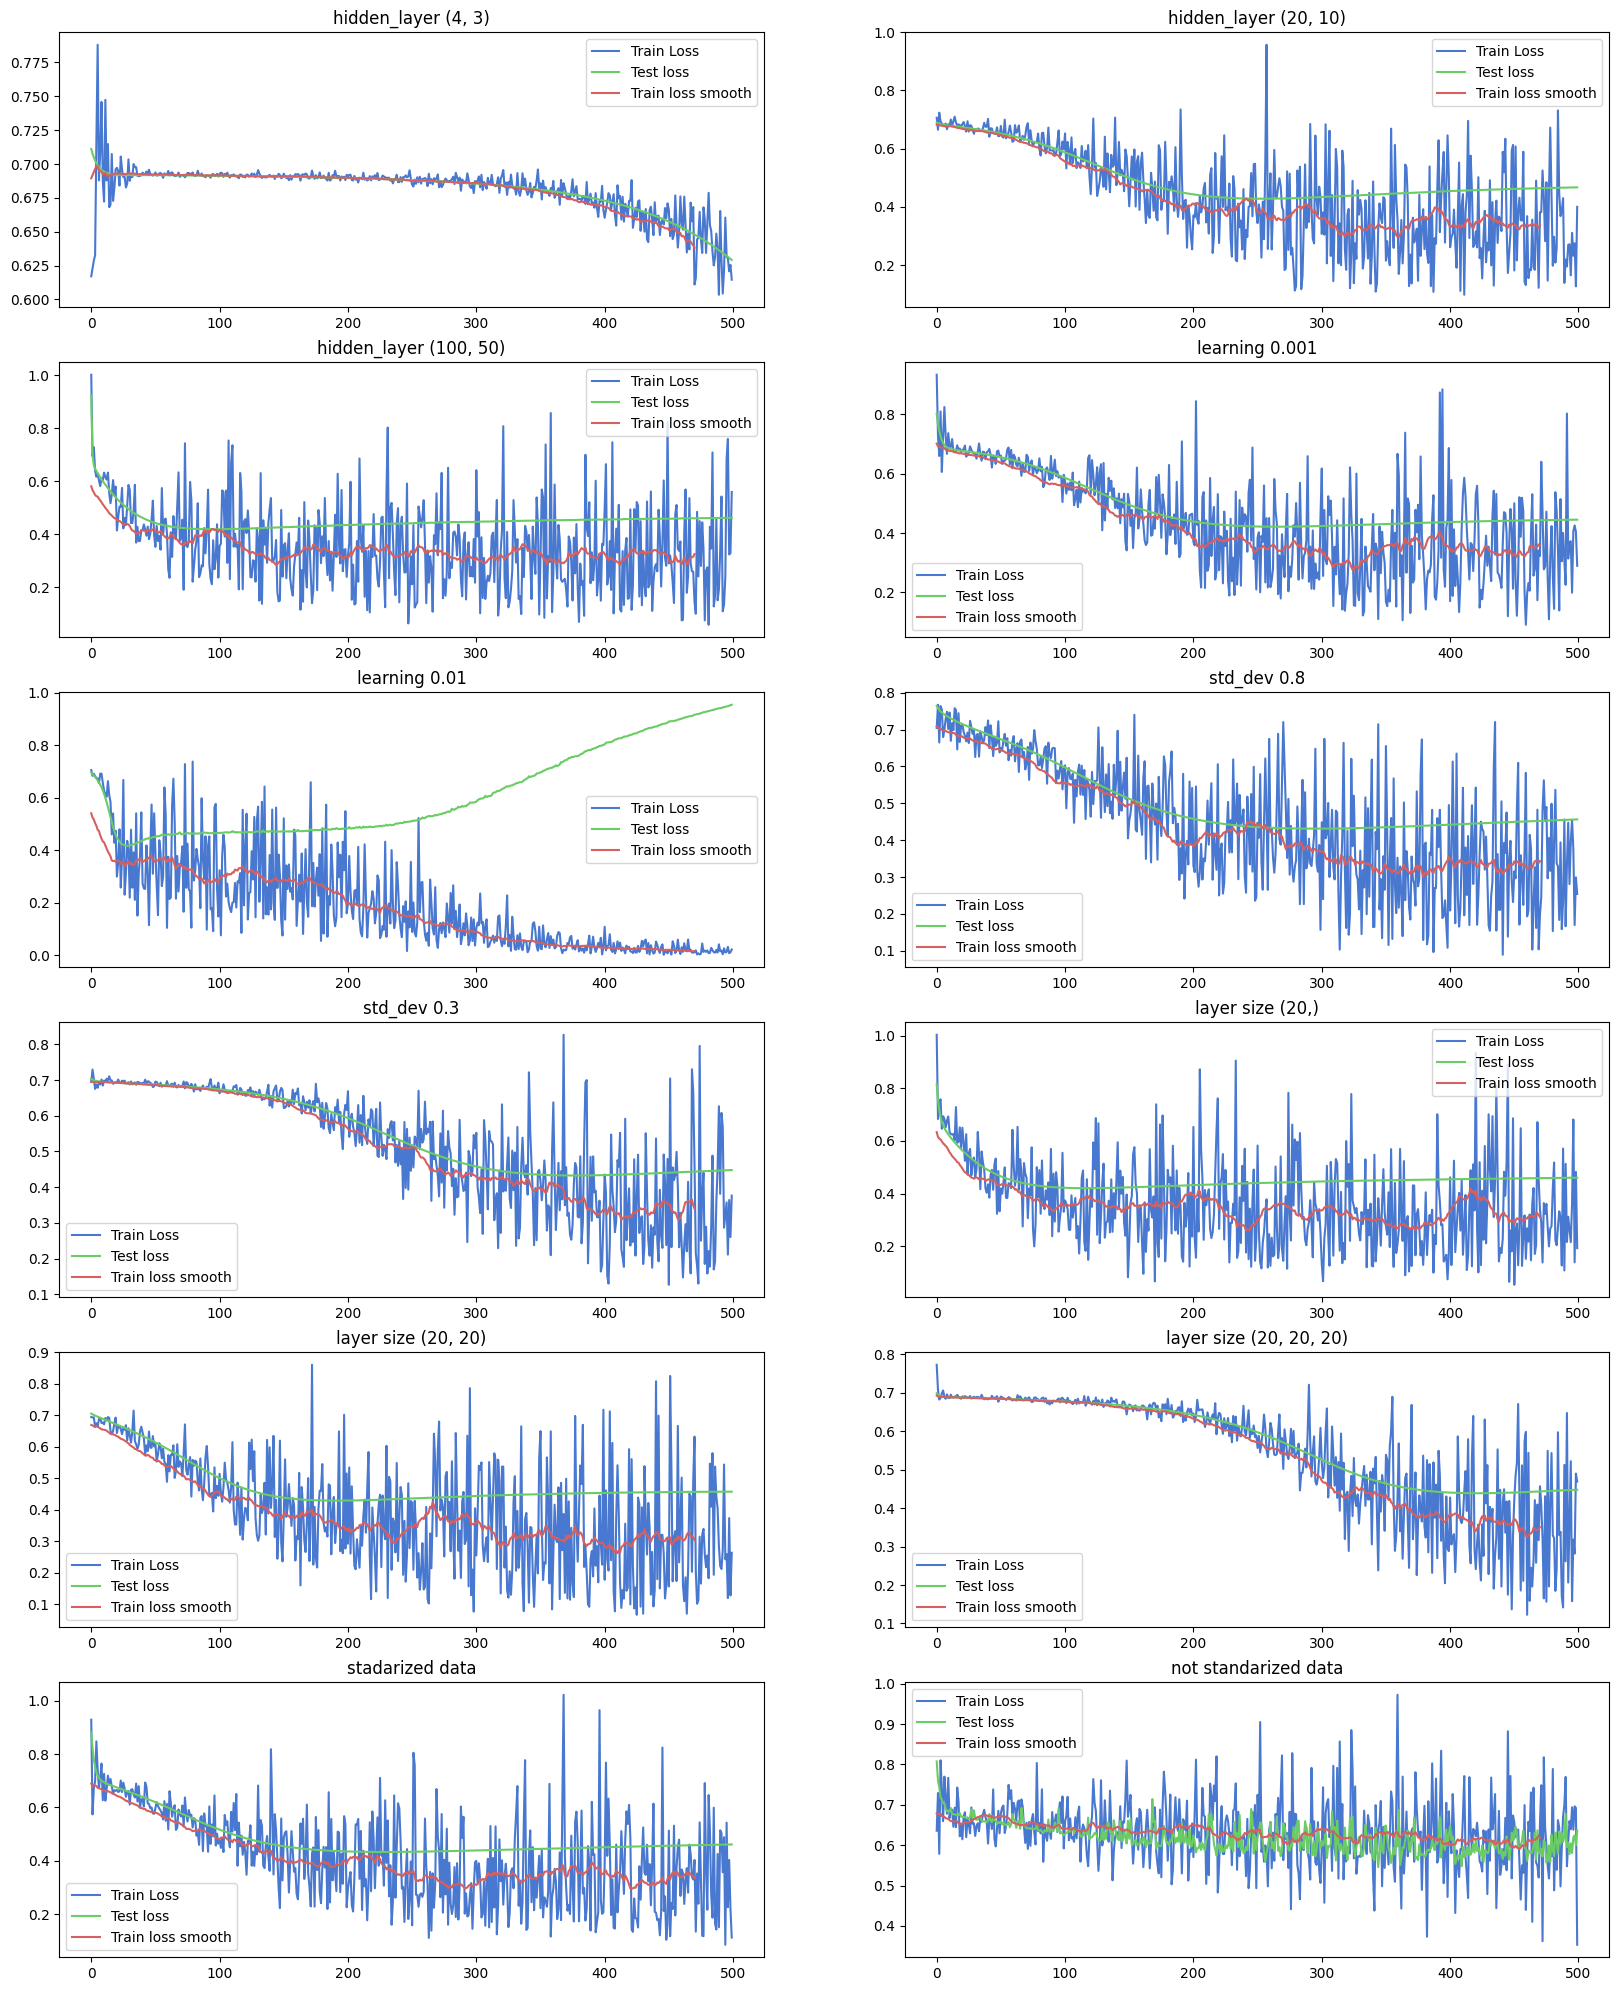

In [13]:
plt.style.use('seaborn-muted')
fig, axs = plt.subplots(6, 2, figsize=(20, 25))

for model_index, model in enumerate(models):
    x_index = int(model_index / 2)
    y_index = int(model_index % 2)
    model.plot_learning(results[model_index][0], results[model_index][1], options_title[model_index], axs[x_index, y_index])
    